In [1]:
import segyio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Rectangle
from matplotlib.ticker import PercentFormatter
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import os
from string import ascii_lowercase, ascii_uppercase

plt.style.use('./mpl/manuscript.mplstyle')
plt.rcParams['figure.figsize'] = plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][0] #7.85

data_path = '../../data/seismic/'

In [2]:
def get_seismic(path):
    with segyio.open(os.path.join(data_path, path), strict=False) as f:
        z = np.array(f.samples)
        x = np.arange(len(f.trace)) * 1.
        cdp = np.empty(len(f.trace), dtype=int)
        data = np.empty((z.size, x.size), dtype=float)
        for i in range(len(f.trace)):
            data[:, i] = f.trace[i]
            cdp[i] = f.header[i][segyio.su.cdp]
        return (x, z), data, cdp

def get_mask(left, right, top, base, x, z):
    xx, zz = np.meshgrid(x, z)
    return (xx >= left) & (xx <= right) & (zz >= top) &  (zz <= base)

In [3]:
profiles = 'TS17_WE44_AUV_mission20_line017_proc.sgy', 'TS17_WE44_AUV_mission29_line028x_proc.sgy'
x = []
z = []
data = []
cdp = []
for profile in profiles:
    (x_0, z_0), data_0, cdp_0 = get_seismic(profile)
    x.append(x_0)
    z.append(z_0)
    data.append(data_0)
    cdp.append(cdp_0)

In [4]:
labels = {
    'Apparent top\nMTD': [(7000, 740, 50, 5), (2400, 922, -20, 20)],
    'Apparent base\nMTD': [(6750, 760, -45, -25), (2000, 939, 40, -25)],
    'Headscarp': [(7260, 725, 40, 5), None],
    'Sediment drape': [(6025, 782, 30, 10), (1800, 918, 40, 20)],
    'Waterbottom': [(7500, 713, 40, 5), (3400, 908, 40, 20)],
    'Older MTD': [None, (2650, 942, -40, -12)],
}

core_x = 6322
core_z = 768.5
core_length = 9

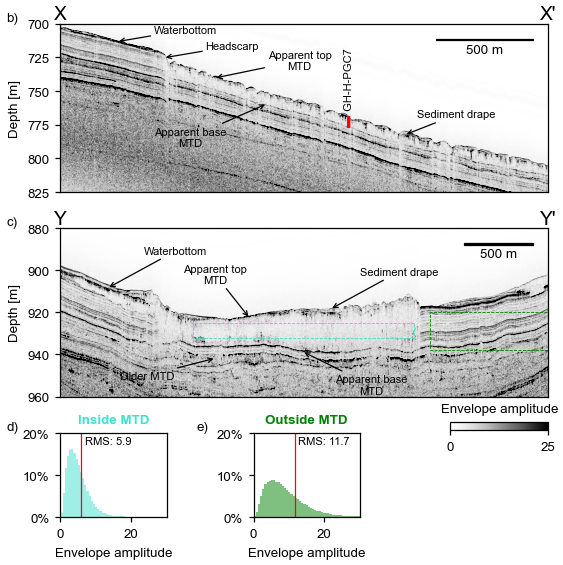

In [5]:
fig = plt.figure(constrained_layout=True)
g = gridspec.GridSpec(3, 3, figure=fig,
                      height_ratios=[1, 1, 0.5],
                      width_ratios=[1, 1, 1],
                      wspace=0,)

sbp = [None, None]
vmin, vmax = 0, 25
xlim = (x[0][-1], x[0][-1] - 2500), (3750, 250)
ylim = (825, 700), (960, 880)

for i in range(len(profiles)):
    sbp[i] = fig.add_subplot(g[i, :])
    extent = [x[i][0], x[i][-1], z[i][-1], z[i][0]]
    a = sbp[i].imshow(data[i], cmap='Greys', vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
    sbp[i].set(xlim=xlim[i], ylim=ylim[i])

    scale_length = 500
    scalebar = AnchoredSizeBar(sbp[i].transData,
                           scale_length, f'{scale_length} m', 'upper right',
                           pad=1,
                           color='black',
                           frameon=False,
                           size_vertical=0.01 * (ylim[i][0] - ylim[i][1]))

    sbp[i].add_artist(scalebar)

    for j, suffix in enumerate(['', '\'']):
        sbp[i].text(float(j), 1.005, ascii_uppercase[23 + i] + suffix, transform=sbp[i].transAxes, va='bottom', ha='center', fontsize='x-large')

kwargs = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0, linewidth=2, capstyle='butt', color='red'))
sbp[0].annotate('', xy=[core_x, core_z + core_length],  xytext=[core_x, core_z], **kwargs)
sbp[0].text(core_x, core_z - 2.5, ' GH-H-PGC7', rotation=90, ha='center', va='bottom', fontsize='small')

#trans = lambda ax: transforms.blended_transform_factory(ax.transAxes, ax.transAxes)
for name, locations in labels.items():
    for i, props in enumerate(locations):
        if props is None:
            continue

        offset = [20, 20]
        if len(props) > 2:
            offset = props[2:4]

        xy = props[0:2]

        relpos = 0.5, 0.5

        sbp[i].annotate(name, xy=xy, xycoords='data', xytext=offset, textcoords='offset points', arrowprops=dict(
            arrowstyle='->', relpos=relpos, shrinkA=0, shrinkB=0
        ), horizontalalignment='center', fontsize='small')

cbaxes = inset_axes(sbp[1], width="20%", height="5%", loc='lower right', bbox_to_anchor=(0, -0.2, 1, 1), bbox_transform=sbp[1].transAxes, borderpad=0)
cbar = fig.colorbar(a, cax=cbaxes, orientation='horizontal', ticks=(vmin, vmax))
cbaxes.set_title('Envelope amplitude')

for a in sbp:
    a.set(ylabel='Depth [m]')
    #a.grid('on')
    a.xaxis.set_ticklabels([])
    a.xaxis.set_ticks([])

rect_1 = 1210, 2800, 925, 932, 'turquoise'
rect_2 = 100, 1100, 920, 938, 'green'

hist = [None, None]

bins = np.linspace(0, 30, 50)
for i, rect in enumerate([rect_1, rect_2]):
    patch = Rectangle((rect[0], rect[2]), rect[1] - rect[0], rect[3] - rect[2], color=rect[4], linestyle='--', lw=0.5, fill=None)
    sbp[1].add_patch(patch)

    hist[i] = fig.add_subplot(g[-1, i])

    arr = ma.array(data[1], mask=~get_mask(*rect[:-1], x[1], z[1]))
    vals = arr.compressed()
    rms = np.sqrt(np.mean(np.square(vals)))
    hist[i].hist(vals, density=True, bins=bins, color=rect[4], alpha=0.5)
    hist[i].axvline(rms, color='red')
    hist[i].annotate(f'RMS: {rms:.1f}', (rms, 1), (2, -2),
                   xycoords=transforms.blended_transform_factory(hist[i].transData, hist[i].transAxes),
                   textcoords='offset points', va='top', fontsize='small')
    hist[i].set(xlabel='Envelope amplitude', xlim=[bins[0], bins[-1]], ylim=[0, 0.2])
    hist[i].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

for title, c, a in ('Inside MTD', 'turquoise', hist[0]), ('Outside MTD', 'green', hist[1]):
    a.set_title(title, fontweight='bold', c=c)

def label_axis(axis, i, offset=(1, 0), second=False):
    if second is not True:
        trans = transforms.blended_transform_factory(fig.transFigure, axis.transAxes)
    else:
        trans = transforms.blended_transform_factory(axis.transAxes, axis.transAxes)
    axis.annotate(f'{ascii_lowercase[i]})', xy=(0.0125, 1), xytext=offset,
                  xycoords=trans, textcoords='offset points',
                  va='bottom', ha='left')

counter = 1
for axis in sbp:
    label_axis(axis, counter)
    counter += 1
label_axis(hist[0], counter)
counter += 1
label_axis(hist[1], counter, second=True, offset=(-35, 0))

plt.show()

In [6]:
for i in 0, 1:
    ind = (x[i] >= min(xlim[i])) & (x[i] <= max(xlim[i]))
    print(min(cdp[i][ind]), max(cdp[i][ind]))

6697 9197
1132 4632


In [7]:
fig.savefig('../../manuscript/figures/fig1b-e-sub-bottom-profiles.pdf', pad_inches=0)

In [8]:
import subprocess

cmd = ['pdfjam', '--no-tidy', '--nup', '1x2', '--papersize', '{120mm,183mm}', '--noautoscale', 'true', '--delta', '0mm 56mm', '../../data/maps/fig1-basemap.pdf', '../../manuscript/figures/fig1b-e-sub-bottom-profiles.pdf', '-o', '../../manuscript/figures/fig01.pdf']
cmd
subprocess.run(cmd)

          ----
  pdfjam: This is pdfjam version 3.03.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Temporary directory for this job is
                    /var/tmp/pdfjam-rGG0b2
  pdfjam: Effective call for this run of pdfjam:
          /usr/local/texlive/2022/bin/x86_64-linux/pdfjam --no-tidy --nup '1x2' --papersize '{120mm,183mm}' --noautoscale 'true' --delta '0mm 56mm' --outfile ../../manuscript/figures/fig01.pdf -- ../../data/maps/fig1-basemap.pdf - ../../manuscript/figures/fig1b-e-sub-bottom-profiles.pdf - 
  pdfjam: Calling /usr/local/texlive/2022/bin/x86_64-linux/pdflatex...
  pdfjam: Finished.  Output was written to '../../manuscript/figures/fig01.pdf'.


CompletedProcess(args=['pdfjam', '--no-tidy', '--nup', '1x2', '--papersize', '{120mm,183mm}', '--noautoscale', 'true', '--delta', '0mm 56mm', '../../data/maps/fig1-basemap.pdf', '../../manuscript/figures/fig1b-e-sub-bottom-profiles.pdf', '-o', '../../manuscript/figures/fig01.pdf'], returncode=0)